In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as  plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn import metrics

In [2]:
df = pd.read_csv(r'C:\Users\maxim\Documents\GitHub\gold-forecast\data\data_nominal_clean.csv', sep=';',  index_col='date',  parse_dates=['date'])
df.head()

,Gold,CrudeOil,S&P500,FTSE250
date,,,,
1986-01-02,326.30,25.56,209.59,1417.26
1986-01-03,326.75,26.00,210.88,1424.61
1986-01-06,328.00,26.53,210.65,1430.96
1986-01-07,330.00,25.85,213.80,1421.22
1986-01-08,332.60,25.87,207.97,1408.79


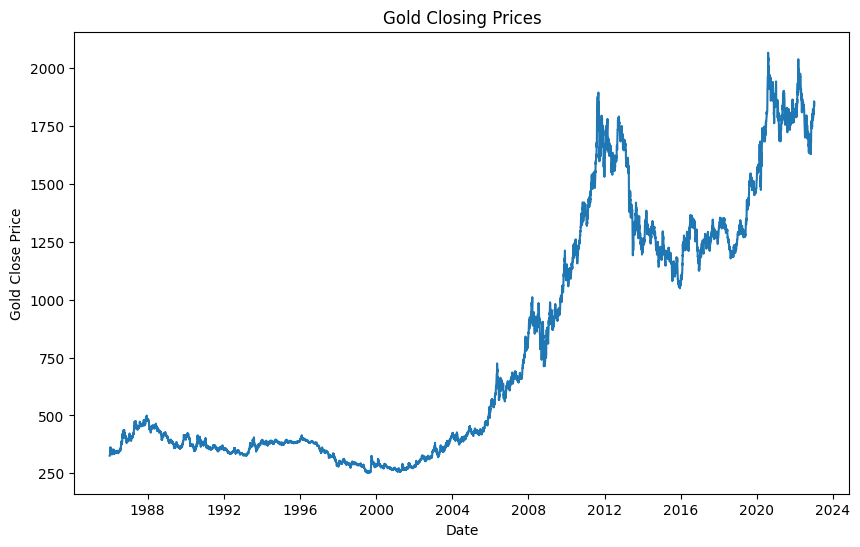

In [3]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.plot(df['Gold'])
plt.title('Gold Closing Prices')
plt.show()

Text(0.5, 1.0, 'Histogram of Gold Prices')

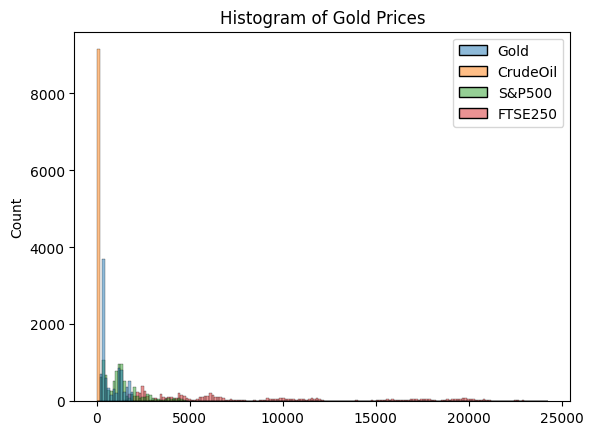

In [4]:
sns.histplot(df)
plt.title('Histogram of Gold Prices')

<AxesSubplot: ylabel='Density'>

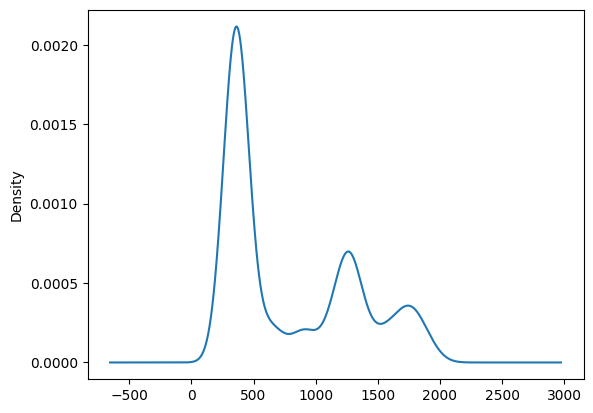

In [5]:
df.Gold.plot(kind='kde')

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


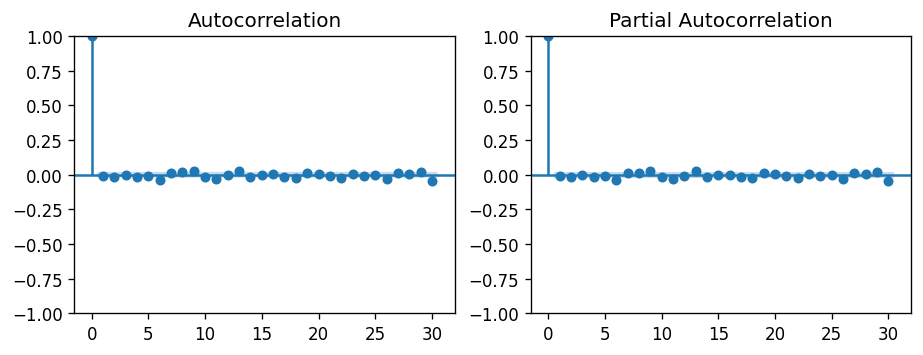

In [6]:
dfac = df.copy()
dfac.reset_index(inplace=True, drop=True)

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
plot_acf(dfac['Gold'].diff().dropna(), ax=axes[0], lags=30)
plot_pacf(dfac['Gold'].diff().dropna(), ax=axes[1], lags=30)

plt.show()

In [10]:
def test_stationarity(timeseries, name):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean and Standard Deviation\n{name}')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

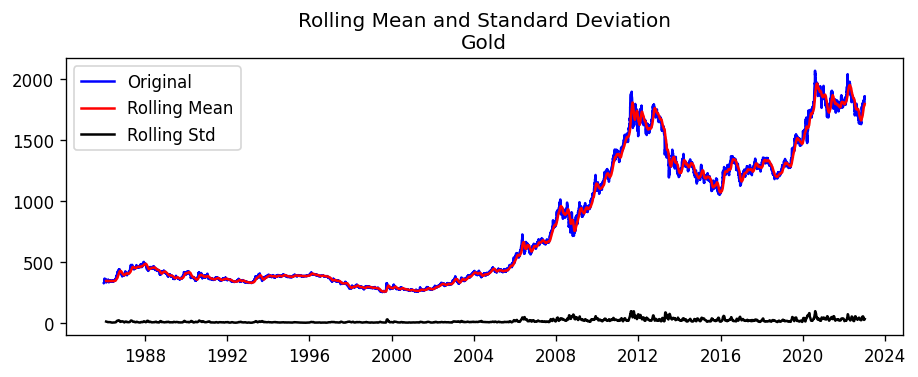

Results of dickey fuller test
Test Statistics                   0.275366
p-value                           0.976186
No. of lags used                 30.000000
Number of observations used    9118.000000
critical value (1%)              -3.431067
critical value (5%)              -2.861857
critical value (10%)             -2.566939
dtype: float64


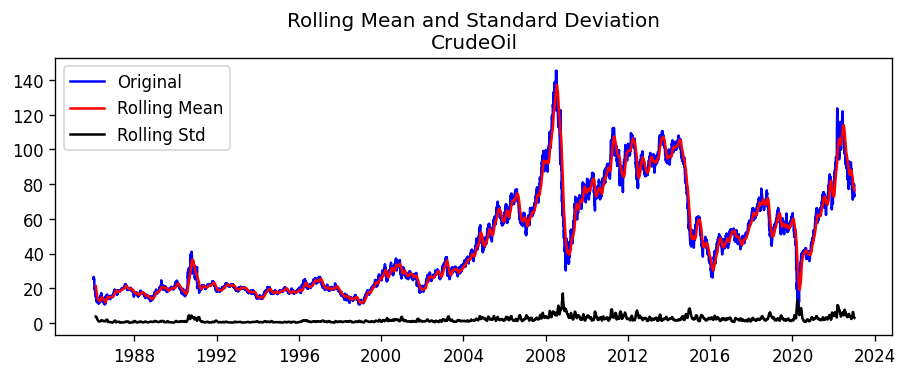

Results of dickey fuller test
Test Statistics                  -2.468645
p-value                           0.123291
No. of lags used                 38.000000
Number of observations used    9110.000000
critical value (1%)              -3.431068
critical value (5%)              -2.861857
critical value (10%)             -2.566939
dtype: float64


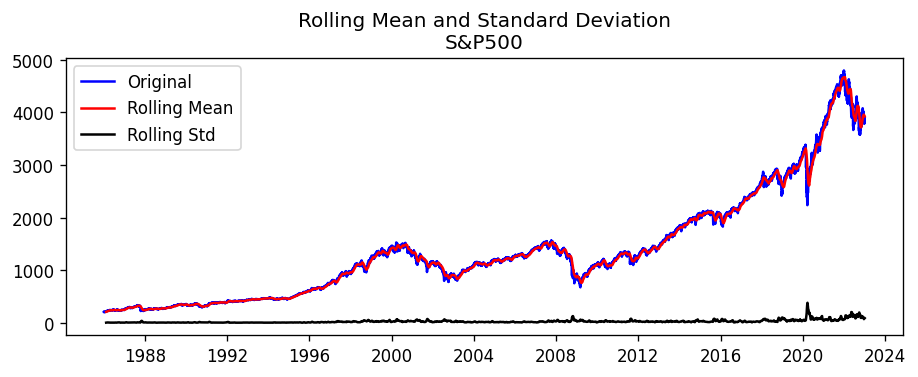

Results of dickey fuller test
Test Statistics                   0.979167
p-value                           0.994041
No. of lags used                 38.000000
Number of observations used    9110.000000
critical value (1%)              -3.431068
critical value (5%)              -2.861857
critical value (10%)             -2.566939
dtype: float64


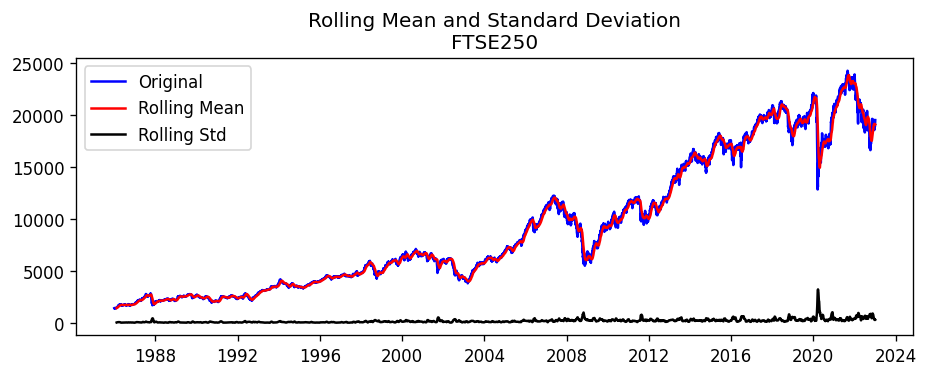

Results of dickey fuller test
Test Statistics                  -0.558719
p-value                           0.880040
No. of lags used                 38.000000
Number of observations used    9110.000000
critical value (1%)              -3.431068
critical value (5%)              -2.861857
critical value (10%)             -2.566939
dtype: float64


In [11]:
for i in df.columns:
    test_stationarity(df[i], i)

<Figure size 1080x360 with 0 Axes>

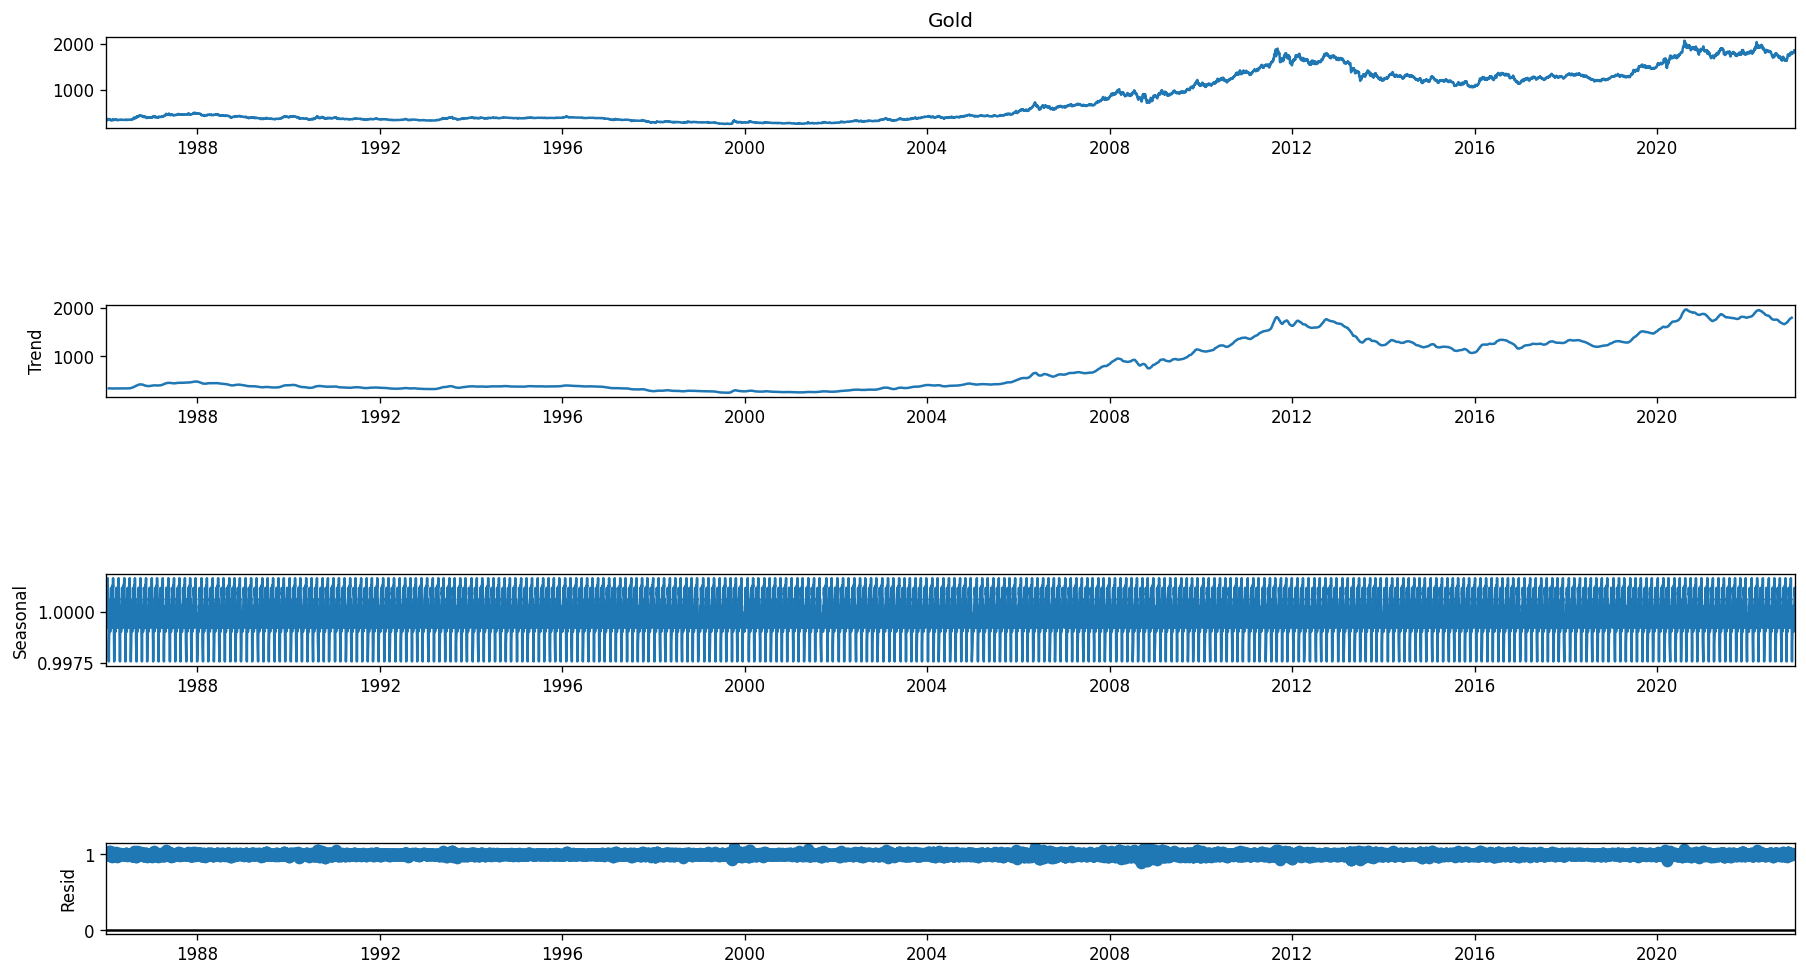

In [12]:
sd_plot  = seasonal_decompose(df['Gold'], model='multiplicative', period=30)
fig = plt.figure()
fig = sd_plot.plot()
fig.set_size_inches(16,10)

Detrending time series 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


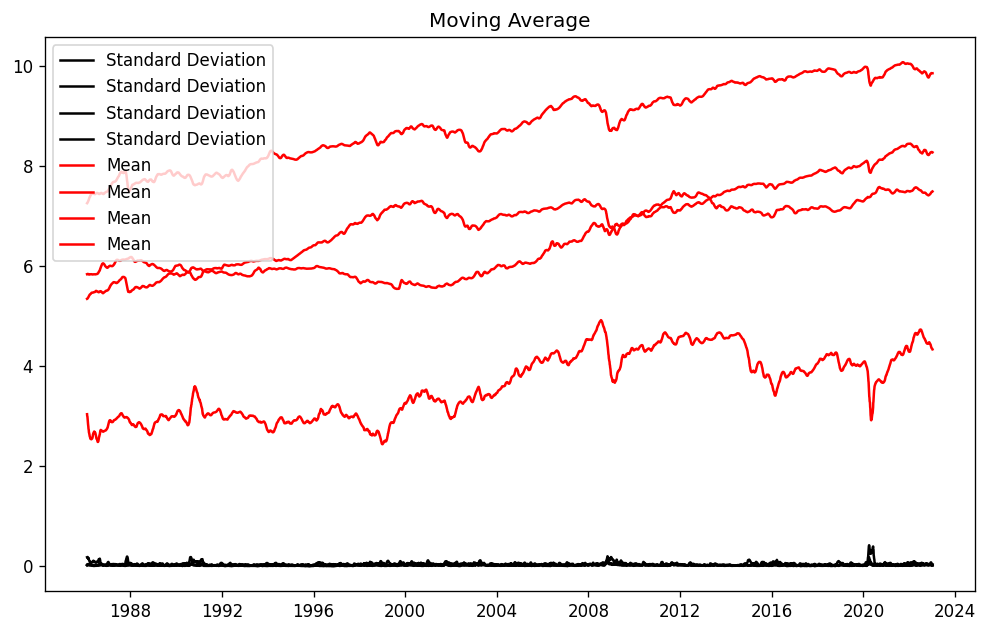

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df)
moving_avg = df_log.rolling(30).mean()
std_dev = df_log.rolling(30).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Data split

In [17]:
df_log

,Gold
date,
1986-01-02,5.787817
1986-01-03,5.789195
1986-01-06,5.793014
1986-01-07,5.799093
1986-01-08,5.806941
...,...
2022-12-30,7.503152
2023-01-03,7.519286
2023-01-04,7.526879


In [17]:
y = df_log['Gold']
X = df_log.drop('Gold', axis=1)

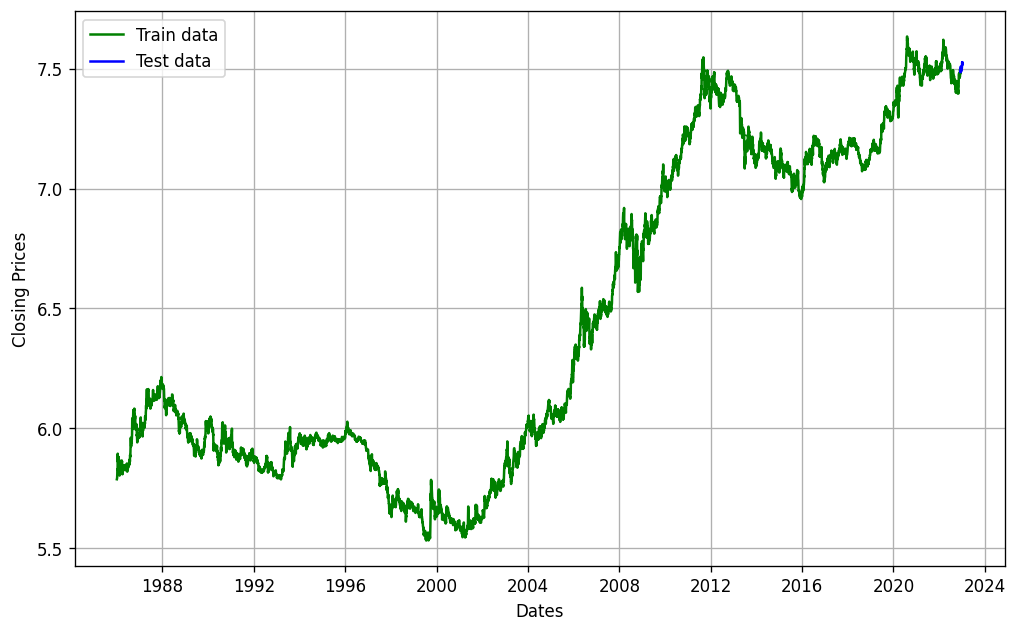

In [21]:
X_train, X_test, y_train, y_test=  X[:-20], X[-20:], y[:-20], y[-20:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend()

# Using only gold price

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58130.627, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58131.669, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58132.523, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58132.552, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58130.541, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-58130.757, Time=2.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58128.525, Time=4.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58131.309, Time=0.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 12.664 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29069.276
Date:                Fri, 31 Mar 2023   AIC                         -58132.552
Time:              

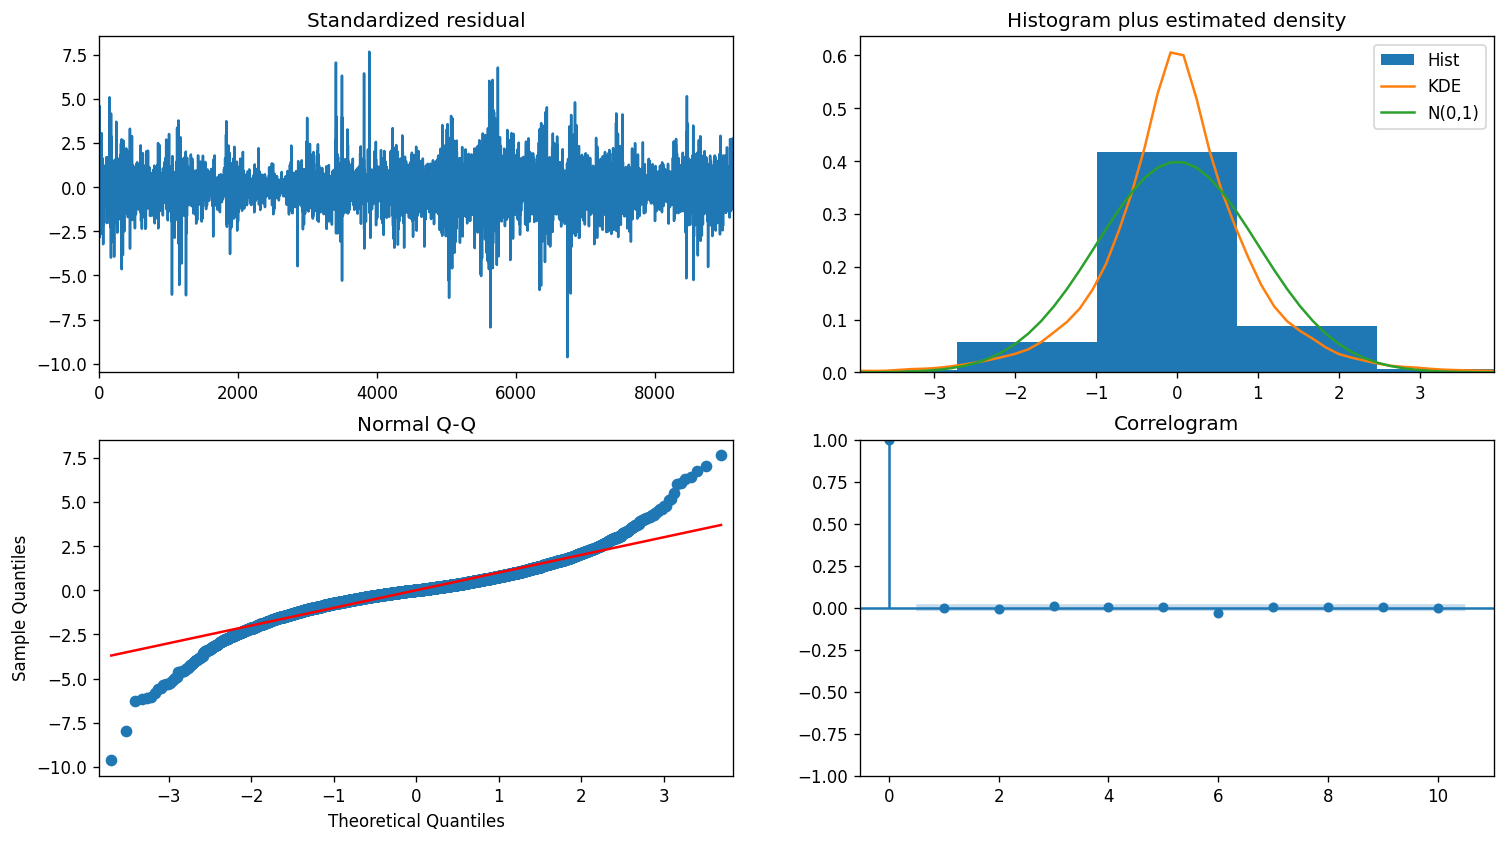

In [49]:
gp_autoARIMA = auto_arima(y_train, 
                      start_p=1, 
                      start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, 
                      max_q=6,          # maximum p and q
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      max_P=2,
                      #max_D=2,
                      max_Q=2,
                      max_d=2, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=200,
                      scoring='mse')
print(gp_autoARIMA.summary())
gp_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [50]:
model1 = gp_autoARIMA

Fitting  model sugessted above

In [51]:
#model = SARIMAX(train_data, order=(0,1,1), seasonal_order=(0,0,0,0))  
fitted = model1.fit(y_train)  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29069.276
Date:                Fri, 31 Mar 2023   AIC                         -58132.552
Time:                        00:18:31   BIC                         -58111.195
Sample:                             0   HQIC                        -58125.290
                               - 9129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.804      0.071   -1.61e-05       0.000
ma.L1         -0.0177      0.007     -2.430      0.015      -0.032      -0.003
sigma2         0.0001   7.25e-07    138.376      0.0

In [52]:
fc = fitted.predict(20)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [53]:
fc

9129    7.481100
9130    7.481286
9131    7.481472
9132    7.481659
9133    7.481845
9134    7.482031
9135    7.482217
9136    7.482403
9137    7.482589
9138    7.482775
9139    7.482961
9140    7.483147
9141    7.483333
9142    7.483519
9143    7.483705
9144    7.483892
9145    7.484078
9146    7.484264
9147    7.484450
9148    7.484636
dtype: float64

In [54]:
fc = pd.DataFrame(fc)
fc.index = y_test.index
fc

,0
date,
2022-12-07,7.481100
2022-12-08,7.481286
2022-12-09,7.481472
2022-12-12,7.481659
2022-12-13,7.481845
2022-12-14,7.482031
2022-12-15,7.482217
2022-12-16,7.482403
2022-12-19,7.482589


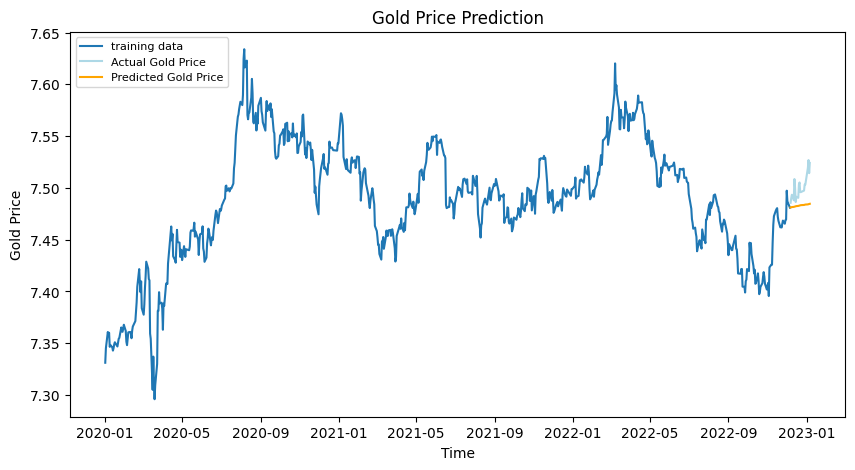

In [55]:
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_train[y_train.index > '2019-12-31'], label='training data')
plt.plot(y_test, color = 'lightblue', label='Actual Gold Price')
plt.plot(fc[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [30]:
y_test

date
2022-12-07    7.485604
2022-12-08    7.490055
2022-12-09    7.493401
2022-12-12    7.488070
2022-12-13    7.508540
2022-12-14    7.500004
2022-12-15    7.486361
2022-12-16    7.491394
2022-12-19    7.490418
2022-12-20    7.503235
2022-12-21    7.505245
2022-12-22    7.495931
2022-12-23    7.495931
2022-12-28    7.497401
2022-12-29    7.503152
2022-12-30    7.503152
2023-01-03    7.519286
2023-01-04    7.526879
2023-01-05    7.514255
2023-01-06    7.524129
Name: Gold, dtype: float64

In [49]:
train_data

,Gold
date,
1986-01-02,5.787817
1986-01-03,5.789195
1986-01-06,5.793014
1986-01-07,5.799093
1986-01-08,5.806941
...,...
2022-11-30,7.469369
2022-12-01,7.497290
2022-12-02,7.487034


# ARIMA with explanatory variables

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58253.076, Time=3.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58250.609, Time=3.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58255.009, Time=2.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-58255.036, Time=4.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-58249.280, Time=6.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-58253.052, Time=4.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-58250.824, Time=12.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58253.524, Time=2.54 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 38.684 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9129
Model:               SARIMAX(0, 1, 1)   Log Likelihood               29133.518
Date:                Fri, 31 Mar 2023   AIC                         -58255.036
Time:             

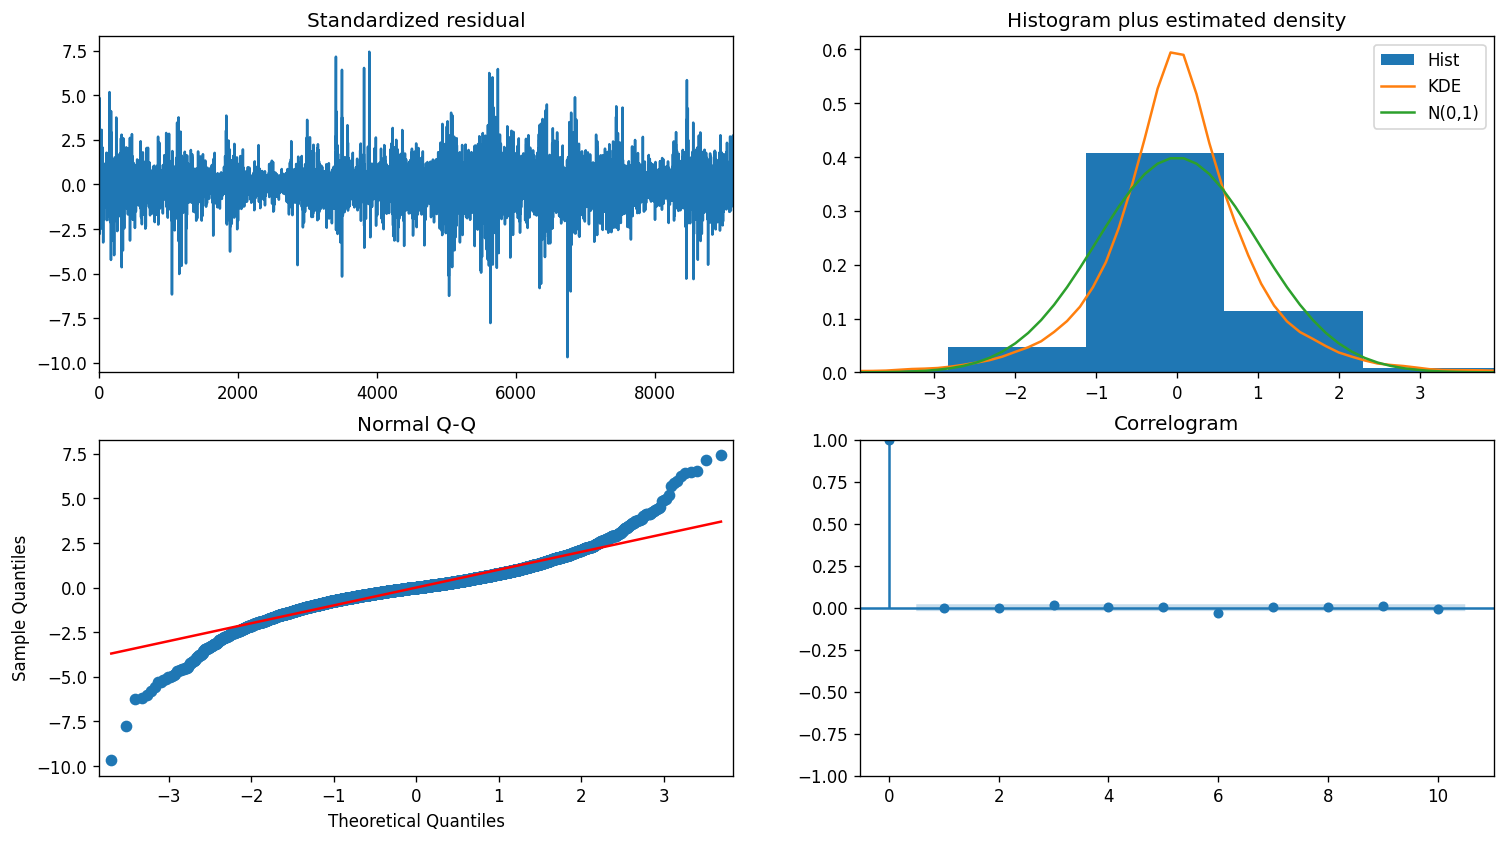

In [43]:
gp_autoARIMA = auto_arima(y=y_train, X=X_train, 
                      start_p=1, 
                      start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, 
                      max_q=6,          # maximum p and q
                      m=7,             # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      max_P=2,
                      #max_D=2,
                      max_Q=2,
                      max_d=2, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter=200,
                      scoring='mse')
print(gp_autoARIMA.summary())
gp_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [44]:
model1 = gp_autoARIMA

In [48]:
model1

ARIMA(maxiter=200, order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [45]:
fc = model1.predict(20, X_test)

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [46]:
fc = pd.DataFrame(fc)
fc.index = y_test.index
fc

,0
date,
2022-12-07,7.479828
2022-12-08,7.479306
2022-12-09,7.479710
2022-12-12,7.480327
2022-12-13,7.481728
2022-12-14,7.483008
2022-12-15,7.483453
2022-12-16,7.482988
2022-12-19,7.484031


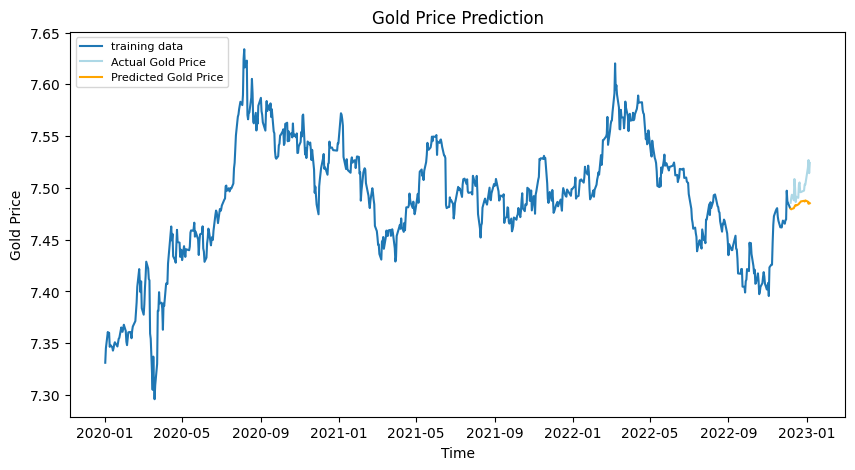

In [47]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_train[y_train.index > '2019-12-31'], label='training data')
plt.plot(y_test, color = 'lightblue', label='Actual Gold Price')
plt.plot(fc[0], color = 'orange',label='Predicted Gold Price')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.10)
plt.title('Gold Price Prediction')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()